# Forecasting Model: NHL (Within Sample Forecast)

In this week, we will expand the notion of forecasting introduced in the previous week by Prof. Stefan Szymanski in which the transfer market value among the teams in EPL serves as a predictor variable as the basis for forecasting model. This section is a logisical extension of the model to the American team sports context. More specifically, we will fit the model for predicting the game results by using the log of the ratio of salaries as an IV variable. Then, we will compare the performance of our forecasting model to the betting odds model. We will use the 2016 regular season data in NHL.

#### Note. The salary information among NHL players were obtained from the web site below. The data were available before the regular season starts so it can be used to "predict" game results for the particular season in advance. Particularly, we used the avarage salary column in the page. 
https://www.spotrac.com/nhl/contracts/

## 1. Data Preparation

### 1.1) Import Libraries & Dataset

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
#Import Data
NHL_game = pd.read_csv("../../Data/Week 4/NHL_game2.csv")
salary = pd.read_csv("../../Data/Week 4/nhl_avg_salary_2016.csv")

### 1.2) Exploratory Data Analysis 

In [4]:
#Display 
display(NHL_game[0:10])
display(salary[0:10])

,comp_id,competition_name,date,gid,goals_against,goals_for,hgd,home_away,team_name,tid,tricode,type,win,win.ord,year
0,2,2017 NHL Regular Season,2018-03-20,2254,3.0,4.0,1.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2017
1,2,2017 NHL Regular Season,2018-03-07,2050,4.0,5.0,1.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2017
2,2,2017 NHL Regular Season,2017-12-06,844,2.0,6.0,4.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2017
3,2,2017 NHL Regular Season,2017-11-23,659,2.0,3.0,1.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2017
4,2,2017 NHL Regular Season,2018-03-13,2147,7.0,4.0,-3.0,home,Tampa Bay Lightning,25,TBL,2,0.0,0.0,2017
5,2,2017 NHL Regular Season,2017-11-04,407,4.0,5.0,1.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2017
6,2,2017 NHL Regular Season,2018-04-01,2439,4.0,1.0,-3.0,home,Tampa Bay Lightning,25,TBL,2,0.0,0.0,2017
7,2,2017 NHL Regular Season,2018-02-18,1797,4.0,3.0,-1.0,home,Tampa Bay Lightning,25,TBL,2,0.0,0.0,2017
8,2,2017 NHL Regular Season,2017-10-09,71,3.0,4.0,1.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2017
9,2,2017 NHL Regular Season,2017-11-17,567,1.0,6.0,5.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2017


,Team,Player,average
0,ANA,Corey PerryRight Wing,8625000
1,ANA,Ryan GetzlafCenter,8250000
2,ANA,Ryan KeslerCenter,6875000
3,ANA,Hampus LindholmDefenseman,5250000
4,ANA,Sami VatanenDefenseman,4875000
5,ANA,Jonathan BernierGoaltender,4150000
6,ANA,Kevin BieksaDefenseman,4000000
7,ANA,Cam FowlerDefenseman,4000000
8,ANA,Rickard RakellCenter,3800000
9,ANA,Jakob SilfverbergRight Wing,3750000


In [5]:
salary.shape

(1034, 3)

In [6]:
salary.describe().round(decimals = 0)

,average
count,1034.0
mean,2354696.0
std,2061992.0
min,547500.0
25%,800000.0
50%,1200000.0
75%,3800000.0
max,10500000.0


In [7]:
#Obtain the list of variables
NHL_game.columns

Index(['comp_id', 'competition_name', 'date', 'gid', 'goals_against',
       'goals_for', 'hgd', 'home_away', 'team_name', 'tid', 'tricode', 'type',
       'win', 'win.ord', 'year'],
      dtype='object')

In [8]:
salary.columns

Index(['Team', 'Player', 'average'], dtype='object')

### 1.3)  Data Cleaning and Organization

In [9]:
# Filter rows for 2016 NHL data
NHL16 = NHL_game[NHL_game.year == 2016].copy()
display(NHL16[0:10])

,comp_id,competition_name,date,gid,goals_against,goals_for,hgd,home_away,team_name,tid,tricode,type,win,win.ord,year
6395,2734,2016 NHL Regular Season,2017-04-01,5038,2.0,1.0,-1.0,home,Tampa Bay Lightning,25,TBL,2,0.0,0.0,2016
6396,2734,2016 NHL Regular Season,2016-11-05,3068,1.0,4.0,3.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2016
6397,2734,2016 NHL Regular Season,2017-03-12,4719,2.0,3.0,1.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2016
6398,2734,2016 NHL Regular Season,2017-01-13,3987,2.0,3.0,1.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2016
6399,2734,2016 NHL Regular Season,2017-03-21,4876,5.0,3.0,-2.0,home,Tampa Bay Lightning,25,TBL,2,0.0,0.0,2016
6400,2734,2016 NHL Regular Season,2017-03-18,4830,5.0,3.0,-2.0,home,Tampa Bay Lightning,25,TBL,2,0.0,0.0,2016
6401,2734,2016 NHL Regular Season,2017-03-30,5008,3.0,5.0,2.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2016
6402,2734,2016 NHL Regular Season,2017-02-28,4555,1.0,5.0,4.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2016
6403,2734,2016 NHL Regular Season,2017-02-05,4271,4.0,5.0,1.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2016
6404,2734,2016 NHL Regular Season,2016-12-04,3462,2.0,3.0,1.0,home,Tampa Bay Lightning,25,TBL,2,1.0,2.0,2016


In [10]:
# Drop unnecessary variables
NHL16.drop(['competition_name','type','year','comp_id', 
            'team_name','date','goals_against','goals_for'], axis=1, inplace=True)

In [11]:
# Check the output 
NHL16.head()

,gid,hgd,home_away,tid,tricode,win,win.ord
6395,5038,-1.0,home,25,TBL,0.0,0.0
6396,3068,3.0,home,25,TBL,1.0,2.0
6397,4719,1.0,home,25,TBL,1.0,2.0
6398,3987,1.0,home,25,TBL,1.0,2.0
6399,4876,-2.0,home,25,TBL,0.0,0.0


Now, we need to change column names for salary data so that we can merge it into hockey data with same column names

In [12]:
salary.rename(columns = {'Team':'tricode'}, inplace = True)
salary.rename(columns = {'average':'salary'}, inplace = True)
salary.head()

,tricode,Player,salary
0,ANA,Corey PerryRight Wing,8625000
1,ANA,Ryan GetzlafCenter,8250000
2,ANA,Ryan KeslerCenter,6875000
3,ANA,Hampus LindholmDefenseman,5250000
4,ANA,Sami VatanenDefenseman,4875000


In [13]:
# Now we aggregate the salary data into team level
team_sal = salary.groupby(['tricode']).sum()
team_sal.head()

,salary
tricode,
ANA,87315833
ARI,72706504
BOS,83407083
BUF,88931190
CAR,63612083


In [14]:
# Merge the resulting salary data into NHL16 data
NHL16=pd.merge(NHL16, team_sal, on=['tricode'])
NHL16.head()

,gid,hgd,home_away,tid,tricode,win,win.ord,salary
0,5038,-1.0,home,25,TBL,0.0,0.0,75863750
1,3068,3.0,home,25,TBL,1.0,2.0,75863750
2,4719,1.0,home,25,TBL,1.0,2.0,75863750
3,3987,1.0,home,25,TBL,1.0,2.0,75863750
4,4876,-2.0,home,25,TBL,0.0,0.0,75863750


## 2. Data Manipulation

Now, let's take a close look at the way each game is structured in our dataframe. As you can see, the data is structured for home and away team separately, so there are two rows for home and away in each game. If you get confused, take a look at the game id(gid) and you will notice that there are two identical game IDs for home and away team as each row recorded the variables for home and away respectively. This means that we need to aggregate the away team salary data next to the home salary data in a corresponding match so that we can use the salary ratio as IV for forecating.

In [15]:
# Extract home and away data 
NHL16home = NHL16[NHL16.home_away == 'home'].copy()
NHL16away = NHL16[NHL16.home_away == 'away'].copy()

In [16]:
#Check the output
NHL16home.head()

,gid,hgd,home_away,tid,tricode,win,win.ord,salary
0,5038,-1.0,home,25,TBL,0.0,0.0,75863750
1,3068,3.0,home,25,TBL,1.0,2.0,75863750
2,4719,1.0,home,25,TBL,1.0,2.0,75863750
3,3987,1.0,home,25,TBL,1.0,2.0,75863750
4,4876,-2.0,home,25,TBL,0.0,0.0,75863750


In [17]:
NHL16away.head()

,gid,hgd,home_away,tid,tricode,win,win.ord,salary
41,4921,-1.0,away,25,TBL,1.0,2.0,75863750
42,3753,4.0,away,25,TBL,0.0,0.0,75863750
43,4607,3.0,away,25,TBL,0.0,0.0,75863750
44,3941,4.0,away,25,TBL,0.0,0.0,75863750
45,3226,-3.0,away,25,TBL,1.0,2.0,75863750


In [18]:
#Drop unnecessary columns from NHL16away data set before merging it to NHL16home
NHL16away.drop(['hgd', 'win', 'win.ord'], axis=1, inplace=True)

In [19]:
NHL16away.head()

,gid,home_away,tid,tricode,salary
41,4921,away,25,TBL,75863750
42,3753,away,25,TBL,75863750
43,4607,away,25,TBL,75863750
44,3941,away,25,TBL,75863750
45,3226,away,25,TBL,75863750


In [20]:
# Merge away team salary data on gid 
NHL16=pd.merge(NHL16home, NHL16away, on=['gid'])
NHL16.head()

,gid,hgd,home_away_x,tid_x,tricode_x,win,win.ord,salary_x,home_away_y,tid_y,tricode_y,salary_y
0,5038,-1.0,home,25,TBL,0.0,0.0,75863750,away,2,MTL,81678810
1,3068,3.0,home,25,TBL,1.0,2.0,75863750,away,29,NJD,71104763
2,4719,1.0,home,25,TBL,1.0,2.0,75863750,away,45,FLA,78996666
3,3987,1.0,home,25,TBL,1.0,2.0,75863750,away,17,BUF,88931190
4,4876,-2.0,home,25,TBL,0.0,0.0,75863750,away,43,ARI,72706504


The data frame now contains the salary data for both home and away team in the same row. Note that the added variables contained same variable names. The python distinguished these two variables by putting "_x" for home and "_y" for away team records. We changed the name of each of variable below.

In [21]:
# Change the column names
NHL16.rename(columns={'tid_x':'tid_home'}, inplace=True)
NHL16.rename(columns={'tid_y':'tid_away'}, inplace=True)
NHL16.rename(columns={'tricode_x':'tricode_home'}, inplace=True)
NHL16.rename(columns={'tricode_y':'tricode_away'}, inplace=True)
NHL16.rename(columns={'salary_x':'salary_home'}, inplace=True)
NHL16.rename(columns={'salary_y':'salary_away'}, inplace=True)

In [22]:
# Taking logs of home team and away team salaries
NHL16['lg_home_sal']=np.log(NHL16['salary_home'])
NHL16['lg_away_sal']=np.log(NHL16['salary_away'])

In [23]:
NHL16.head()

,gid,hgd,home_away_x,tid_home,tricode_home,win,win.ord,salary_home,home_away_y,tid_away,tricode_away,salary_away,lg_home_sal,lg_away_sal
0,5038,-1.0,home,25,TBL,0.0,0.0,75863750,away,2,MTL,81678810,18.14445,18.218305
1,3068,3.0,home,25,TBL,1.0,2.0,75863750,away,29,NJD,71104763,18.14445,18.079665
2,4719,1.0,home,25,TBL,1.0,2.0,75863750,away,45,FLA,78996666,18.14445,18.184916
3,3987,1.0,home,25,TBL,1.0,2.0,75863750,away,17,BUF,88931190,18.14445,18.303373
4,4876,-2.0,home,25,TBL,0.0,0.0,75863750,away,43,ARI,72706504,18.14445,18.101941


In [24]:
NHL16.drop(['home_away_x', 'tid_home','salary_home', 'home_away_y','tid_away','salary_away'], axis=1, inplace=True)

In [25]:
NHL16.head()

,gid,hgd,tricode_home,win,win.ord,tricode_away,lg_home_sal,lg_away_sal
0,5038,-1.0,TBL,0.0,0.0,MTL,18.14445,18.218305
1,3068,3.0,TBL,1.0,2.0,NJD,18.14445,18.079665
2,4719,1.0,TBL,1.0,2.0,FLA,18.14445,18.184916
3,3987,1.0,TBL,1.0,2.0,BUF,18.14445,18.303373
4,4876,-2.0,TBL,0.0,0.0,ARI,18.14445,18.101941


## 3. Forecasting Model



### 3.1) Forecast using the OLS Model: 
#### Dependent Variable: Home goal difference (hgd) 

Instruction: 
- Fit the OLS model using hgd as DV and log scaled home and away salaries as IVs
- Interpret the results


In [26]:
NHL16['lghtsal_ratio']= NHL16['lg_home_sal'] - NHL16['lg_away_sal']

In [27]:
GDreg_lm = smf.ols(formula = 'hgd ~ lghtsal_ratio', data=NHL16).fit()
GDreg_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    hgd   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     27.15
Date:                Tue, 23 Feb 2021   Prob (F-statistic):           2.19e-07
Time:                        17:05:02   Log-Likelihood:                -2934.8
No. Observations:                1296   AIC:                             5874.
Df Residuals:                    1294   BIC:                             5884.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.3207      0.065      4.953      0.000       0.194       0.448
lghtsal_ratio     3.0790      0.591      5.210      0.000       1.920       4.238
==============================================================================
Omnibus:                        4.503   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.195
Skew:                           0.092   Prob(JB):                        0.123
Kurtosis:                       2.791   Cond. No.                         9.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

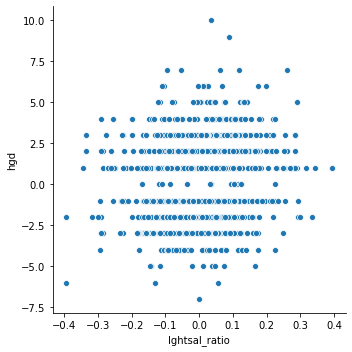

In [28]:
sns.relplot(x = 'lghtsal_ratio', y = 'hgd', data = NHL16)

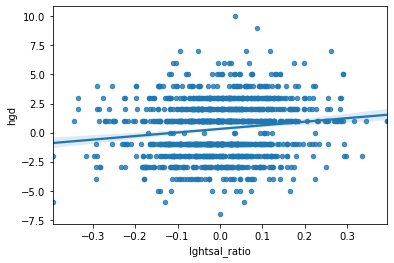

In [29]:
sns.regplot(x = 'lghtsal_ratio', y = 'hgd', data = NHL16, scatter_kws={'s':20})

In [30]:
NHL16['GDpred'] = GDreg_lm.predict()
NHL16.head()

,gid,hgd,tricode_home,win,win.ord,tricode_away,lg_home_sal,lg_away_sal,lghtsal_ratio,GDpred
0,5038,-1.0,TBL,0.0,0.0,MTL,18.14445,18.218305,-0.073856,0.093341
1,3068,3.0,TBL,1.0,2.0,NJD,18.14445,18.079665,0.064785,0.520214
2,4719,1.0,TBL,1.0,2.0,FLA,18.14445,18.184916,-0.040467,0.196146
3,3987,1.0,TBL,1.0,2.0,BUF,18.14445,18.303373,-0.158924,-0.168584
4,4876,-2.0,TBL,0.0,0.0,ARI,18.14445,18.101941,0.042508,0.451625


In [31]:
#If the fitted GD >0, we predict home win (2), otherwise away win(0)
NHL16['resGDpred'] = np.where(NHL16['GDpred']>0, 2, 0)
NHL16.head()

,gid,hgd,tricode_home,win,win.ord,tricode_away,lg_home_sal,lg_away_sal,lghtsal_ratio,GDpred,resGDpred
0,5038,-1.0,TBL,0.0,0.0,MTL,18.14445,18.218305,-0.073856,0.093341,2
1,3068,3.0,TBL,1.0,2.0,NJD,18.14445,18.079665,0.064785,0.520214,2
2,4719,1.0,TBL,1.0,2.0,FLA,18.14445,18.184916,-0.040467,0.196146,2
3,3987,1.0,TBL,1.0,2.0,BUF,18.14445,18.303373,-0.158924,-0.168584,0
4,4876,-2.0,TBL,0.0,0.0,ARI,18.14445,18.101941,0.042508,0.451625,2


In [32]:
NHL16['GDcorrect'] = np.where(NHL16['resGDpred'] == NHL16['win.ord'], 1, 0)


In [33]:
sum(NHL16['GDcorrect'])/1296

0.5694444444444444

#### The GD model "predicted" 56.9% of the game results

### 3.2) Forecasting with Ordinal Logistic Regression

In [34]:
# Import bevel library to fit ordit model
from bevel.linear_ordinal_regression import OrderedLogit
ol = OrderedLogit()

In [35]:
ol.fit(NHL16['lghtsal_ratio'], NHL16['win.ord'])
ol.print_summary()

n=1296
                  beta  se(beta)      p  lower 0.95  upper 0.95     
attribute names                                                     
column_1        2.4702    0.5236 0.0000      1.4438      3.4965  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Somers' D = 0.110


In [36]:
# Obtain the coefficients and the intercepts
print(f'beta = {ol.coef_[0]:.4f}')
print(f'intercept L|D = {ol.coef_[1]:.4f}')
print(f'intercept D|W = {ol.coef_[2]:.4f}')
print(ol.coef_)

beta = 2.4702
intercept L|D = -0.2505
intercept D|W = -0.2091
[ 2.4701532  -0.25047135 -0.20910968]


Here we need to manipulate the coefficient to generate the predicted probabilities for each outcome. 

In [37]:
# Obtain the fitted probabilites for each outcome of the game using the ordit model
NHL16['predL'] = 1/(1+np.exp(-(ol.coef_[1]-ol.coef_[0]*NHL16['lghtsal_ratio'])))
NHL16['predD'] = 1/(1+np.exp(-(ol.coef_[2]-ol.coef_[0]*NHL16['lghtsal_ratio']))) - NHL16['predL']
NHL16['predW'] = 1- NHL16['predL'] - NHL16['predD']

display(NHL16[0:9])

,gid,hgd,tricode_home,win,win.ord,tricode_away,lg_home_sal,lg_away_sal,lghtsal_ratio,GDpred,resGDpred,GDcorrect,predL,predD,predW
0,5038,-1.0,TBL,0.0,0.0,MTL,18.14445,18.218305,-0.073856,0.093341,2,0,0.482997,0.010334,0.506668
1,3068,3.0,TBL,1.0,2.0,NJD,18.14445,18.079665,0.064785,0.520214,2,1,0.398792,0.009957,0.591251
2,4719,1.0,TBL,1.0,2.0,FLA,18.14445,18.184916,-0.040467,0.196146,2,1,0.462443,0.010297,0.527261
3,3987,1.0,TBL,1.0,2.0,BUF,18.14445,18.303373,-0.158924,-0.168584,0,0,0.535464,0.010272,0.454264
4,4876,-2.0,TBL,0.0,0.0,ARI,18.14445,18.101941,0.042508,0.451625,2,0,0.412056,0.010056,0.577888
5,4830,-2.0,TBL,0.0,0.0,WSH,18.14445,18.258475,-0.114026,-0.030343,0,1,0.507797,0.010333,0.481870
6,5008,2.0,TBL,1.0,2.0,DET,18.14445,18.195436,-0.050986,0.163757,2,1,0.468908,0.010312,0.520780
7,4555,4.0,TBL,1.0,2.0,OTT,18.14445,18.245165,-0.100716,0.010639,2,1,0.499578,0.010339,0.490083
8,4271,1.0,TBL,1.0,2.0,ANA,18.14445,18.285042,-0.140593,-0.112142,0,0,0.524185,0.010304,0.465511


In [38]:
# Create a fitted ordinal variabe by using the fitted probabilities
NHL16.loc[(NHL16.predL > NHL16.predW) & (NHL16.predL > NHL16.predD), 'fitted'] = 0
NHL16.loc[(NHL16.predW > NHL16.predL) & (NHL16.predW > NHL16.predD), 'fitted'] = 2
NHL16.loc[(NHL16.predD > NHL16.predW) & (NHL16.predD > NHL16.predL), 'fitted'] = 1

In [39]:
display(NHL16[0:10])

,gid,hgd,tricode_home,win,win.ord,tricode_away,lg_home_sal,lg_away_sal,lghtsal_ratio,GDpred,resGDpred,GDcorrect,predL,predD,predW,fitted
0,5038,-1.0,TBL,0.0,0.0,MTL,18.14445,18.218305,-0.073856,0.093341,2,0,0.482997,0.010334,0.506668,2.0
1,3068,3.0,TBL,1.0,2.0,NJD,18.14445,18.079665,0.064785,0.520214,2,1,0.398792,0.009957,0.591251,2.0
2,4719,1.0,TBL,1.0,2.0,FLA,18.14445,18.184916,-0.040467,0.196146,2,1,0.462443,0.010297,0.527261,2.0
3,3987,1.0,TBL,1.0,2.0,BUF,18.14445,18.303373,-0.158924,-0.168584,0,0,0.535464,0.010272,0.454264,0.0
4,4876,-2.0,TBL,0.0,0.0,ARI,18.14445,18.101941,0.042508,0.451625,2,0,0.412056,0.010056,0.577888,2.0
5,4830,-2.0,TBL,0.0,0.0,WSH,18.14445,18.258475,-0.114026,-0.030343,0,1,0.507797,0.010333,0.481870,0.0
6,5008,2.0,TBL,1.0,2.0,DET,18.14445,18.195436,-0.050986,0.163757,2,1,0.468908,0.010312,0.520780,2.0
7,4555,4.0,TBL,1.0,2.0,OTT,18.14445,18.245165,-0.100716,0.010639,2,1,0.499578,0.010339,0.490083,0.0
8,4271,1.0,TBL,1.0,2.0,ANA,18.14445,18.285042,-0.140593,-0.112142,0,0,0.524185,0.010304,0.465511,0.0
9,3462,1.0,TBL,1.0,2.0,WSH,18.14445,18.258475,-0.114026,-0.030343,0,0,0.507797,0.010333,0.481870,0.0


In [40]:
# Evaluate the accuracy of the forecasting model
NHL16['TRUE'] = np.where(NHL16['fitted']==NHL16['win.ord'], 1, 0)
display(NHL16[0:9])

,gid,hgd,tricode_home,win,win.ord,tricode_away,lg_home_sal,lg_away_sal,lghtsal_ratio,GDpred,resGDpred,GDcorrect,predL,predD,predW,fitted,TRUE
0,5038,-1.0,TBL,0.0,0.0,MTL,18.14445,18.218305,-0.073856,0.093341,2,0,0.482997,0.010334,0.506668,2.0,0
1,3068,3.0,TBL,1.0,2.0,NJD,18.14445,18.079665,0.064785,0.520214,2,1,0.398792,0.009957,0.591251,2.0,1
2,4719,1.0,TBL,1.0,2.0,FLA,18.14445,18.184916,-0.040467,0.196146,2,1,0.462443,0.010297,0.527261,2.0,1
3,3987,1.0,TBL,1.0,2.0,BUF,18.14445,18.303373,-0.158924,-0.168584,0,0,0.535464,0.010272,0.454264,0.0,0
4,4876,-2.0,TBL,0.0,0.0,ARI,18.14445,18.101941,0.042508,0.451625,2,0,0.412056,0.010056,0.577888,2.0,0
5,4830,-2.0,TBL,0.0,0.0,WSH,18.14445,18.258475,-0.114026,-0.030343,0,1,0.507797,0.010333,0.481870,0.0,1
6,5008,2.0,TBL,1.0,2.0,DET,18.14445,18.195436,-0.050986,0.163757,2,1,0.468908,0.010312,0.520780,2.0,1
7,4555,4.0,TBL,1.0,2.0,OTT,18.14445,18.245165,-0.100716,0.010639,2,1,0.499578,0.010339,0.490083,0.0,0
8,4271,1.0,TBL,1.0,2.0,ANA,18.14445,18.285042,-0.140593,-0.112142,0,0,0.524185,0.010304,0.465511,0.0,0


In [41]:
# Obtain the success rate of the model in predicting the outcomes of 2016 regual season
Total = NHL16['TRUE'].sum()
print(Total/1296)

0.5717592592592593


#### The salary ratio model "predicted" 57.1% of the game results

## 4. Forecasting with Betting Odds 

We will compare the fit of a model of results based on salary ratio to the betting odds

In [42]:
# import the betting odds data
odds = pd.read_csv("../../Data/Week 4/odds2016.csv")
odds.head()

,home,tricode.home,tid.home,away,tricode.a,tid.away,X1,h,d,a,gid
0,Anaheim Ducks,ANA,21,Vancouver Canucks,VAN,53.0,80.0,-122,304,272,2892
1,Anaheim Ducks,ANA,21,Nashville Predators,NSH,19.0,97.0,168,286,129,2927
2,Anaheim Ducks,ANA,21,Columbus Blue Jackets,CBJ,52.0,112.0,-125,313,271,2957
3,Anaheim Ducks,ANA,21,Pittsburgh Penguins,PIT,8.0,145.0,192,281,117,3025
4,Anaheim Ducks,ANA,21,Arizona Coyotes,ARI,43.0,160.0,-137,316,305,3056


## It should be noted that the betting odds are recorded in the form of moneyline odds.

Now we calcuate probabilites of each outcome from the betting odds

In [43]:
odds['h_prb'] = np.where(odds['h']<0, -(odds['h'])/(-(odds['h'])+100), 100/(odds['h']+100))
odds['d_prb'] = np.where(odds['d']<0, -(odds['d'])/(-(odds['d'])+100), 100/(odds['d']+100))
odds['a_prb'] = np.where(odds['a']<0, -(odds['a'])/(-(odds['a'])+100), 100/(odds['a']+100))

odds.head()

,home,tricode.home,tid.home,away,tricode.a,tid.away,X1,h,d,a,gid,h_prb,d_prb,a_prb
0,Anaheim Ducks,ANA,21,Vancouver Canucks,VAN,53.0,80.0,-122,304,272,2892,0.549550,0.247525,0.268817
1,Anaheim Ducks,ANA,21,Nashville Predators,NSH,19.0,97.0,168,286,129,2927,0.373134,0.259067,0.436681
2,Anaheim Ducks,ANA,21,Columbus Blue Jackets,CBJ,52.0,112.0,-125,313,271,2957,0.555556,0.242131,0.269542
3,Anaheim Ducks,ANA,21,Pittsburgh Penguins,PIT,8.0,145.0,192,281,117,3025,0.342466,0.262467,0.460829
4,Anaheim Ducks,ANA,21,Arizona Coyotes,ARI,43.0,160.0,-137,316,305,3056,0.578059,0.240385,0.246914


Then define outcomes from the probabilities of each outcome.

In [44]:
odds.loc[(odds.a_prb > odds.h_prb) & (odds.a_prb > odds.d_prb), 'odds_fitted'] = 0
odds.loc[(odds.h_prb > odds.a_prb) & (odds.h_prb > odds.d_prb), 'odds_fitted'] = 2
odds.loc[(odds.d_prb > odds.h_prb) & (odds.d_prb > odds.a_prb), 'odds_fitted'] = 1

In [45]:
odds.head()

,home,tricode.home,tid.home,away,tricode.a,tid.away,X1,h,d,a,gid,h_prb,d_prb,a_prb,odds_fitted
0,Anaheim Ducks,ANA,21,Vancouver Canucks,VAN,53.0,80.0,-122,304,272,2892,0.549550,0.247525,0.268817,2.0
1,Anaheim Ducks,ANA,21,Nashville Predators,NSH,19.0,97.0,168,286,129,2927,0.373134,0.259067,0.436681,0.0
2,Anaheim Ducks,ANA,21,Columbus Blue Jackets,CBJ,52.0,112.0,-125,313,271,2957,0.555556,0.242131,0.269542,2.0
3,Anaheim Ducks,ANA,21,Pittsburgh Penguins,PIT,8.0,145.0,192,281,117,3025,0.342466,0.262467,0.460829,0.0
4,Anaheim Ducks,ANA,21,Arizona Coyotes,ARI,43.0,160.0,-137,316,305,3056,0.578059,0.240385,0.246914,2.0


We extract predicted outcomes from each model for comparison

In [46]:
# Extract predicted results from betting odds
odds_pred = odds[['gid', 'odds_fitted']]
odds_pred.head()

,gid,odds_fitted
0,2892,2.0
1,2927,0.0
2,2957,2.0
3,3025,0.0
4,3056,2.0


In [47]:
# Extract actual results and predicted results from salary ratio model
NHL16_res = NHL16[['gid', 'fitted', 'win.ord']]
NHL16_res.head()

,gid,fitted,win.ord
0,5038,2.0,0.0
1,3068,2.0,2.0
2,4719,2.0,2.0
3,3987,0.0,2.0
4,4876,2.0,0.0


In [48]:
# Merge two models 
NHL16_res = pd.merge(NHL16_res, odds_pred, on=['gid'])

In [49]:
NHL16_res.head()

,gid,fitted,win.ord,odds_fitted
0,5038,2.0,0.0,0.0
1,3068,2.0,2.0,2.0
2,4719,2.0,2.0,2.0
3,3987,0.0,2.0,2.0
4,4876,2.0,0.0,2.0


### The resulting dataframe contains three outcomes
1. Predicted outcomes from the salary ratio model
2. Predicted outcomes from betting odds model
3. Actual outcomes of the season

In [50]:
# Obtain the accurate results from betting odds model
NHL16_res['TRUE'] = np.where(NHL16_res['odds_fitted']==NHL16_res['win.ord'], 1, 0)

In [51]:
# Calculate the success rate
Total = NHL16_res['TRUE'].sum()
print(Total/1296)

0.5802469135802469


#### Summary: The betting odds model "predicted" 58% of the game results and this model performs slightly better than the salary ratio model (57%) 

## 5. Brier Score: Salary Ratio Model vs. Betting Odds Model

We can also compare the performance of each model in the context of Brier score

### 5.1) Data Preparation

In [52]:
NHL16['Houtcome'] = np.where(NHL16['win.ord'] == 2, 1,0)
NHL16['Doutcome'] = np.where(NHL16['win.ord'] == 1, 1,0)
NHL16['Aoutcome'] = np.where(NHL16['win.ord'] == 0, 1,0)
display(NHL16[0:10])

,gid,hgd,tricode_home,win,win.ord,tricode_away,lg_home_sal,lg_away_sal,lghtsal_ratio,GDpred,resGDpred,GDcorrect,predL,predD,predW,fitted,TRUE,Houtcome,Doutcome,Aoutcome
0,5038,-1.0,TBL,0.0,0.0,MTL,18.14445,18.218305,-0.073856,0.093341,2,0,0.482997,0.010334,0.506668,2.0,0,0,0,1
1,3068,3.0,TBL,1.0,2.0,NJD,18.14445,18.079665,0.064785,0.520214,2,1,0.398792,0.009957,0.591251,2.0,1,1,0,0
2,4719,1.0,TBL,1.0,2.0,FLA,18.14445,18.184916,-0.040467,0.196146,2,1,0.462443,0.010297,0.527261,2.0,1,1,0,0
3,3987,1.0,TBL,1.0,2.0,BUF,18.14445,18.303373,-0.158924,-0.168584,0,0,0.535464,0.010272,0.454264,0.0,0,1,0,0
4,4876,-2.0,TBL,0.0,0.0,ARI,18.14445,18.101941,0.042508,0.451625,2,0,0.412056,0.010056,0.577888,2.0,0,0,0,1
5,4830,-2.0,TBL,0.0,0.0,WSH,18.14445,18.258475,-0.114026,-0.030343,0,1,0.507797,0.010333,0.481870,0.0,1,0,0,1
6,5008,2.0,TBL,1.0,2.0,DET,18.14445,18.195436,-0.050986,0.163757,2,1,0.468908,0.010312,0.520780,2.0,1,1,0,0
7,4555,4.0,TBL,1.0,2.0,OTT,18.14445,18.245165,-0.100716,0.010639,2,1,0.499578,0.010339,0.490083,0.0,0,1,0,0
8,4271,1.0,TBL,1.0,2.0,ANA,18.14445,18.285042,-0.140593,-0.112142,0,0,0.524185,0.010304,0.465511,0.0,0,1,0,0
9,3462,1.0,TBL,1.0,2.0,WSH,18.14445,18.258475,-0.114026,-0.030343,0,0,0.507797,0.010333,0.481870,0.0,0,1,0,0


### 5.2) Brier score for salary ratio model

In [53]:
BrierSalary = ((NHL16['predW'] - NHL16['Houtcome'])**2 + (NHL16['predD'] - NHL16['Doutcome'])**2 +\
             (NHL16['predL'] - NHL16['Aoutcome'])**2).sum()/1296

BrierSalary

0.49493678139339253

### 5.3) Brier score for betting odds model

In [54]:
# Extract columns 
NHL16_dummy = NHL16[['gid', 'Houtcome', 'Doutcome', 'Aoutcome']]

In [55]:
# Merge betting odds data by using gid as a key column to match the results accordingly
odds = pd.merge(odds, NHL16_dummy, on=['gid'])
display(odds[:10])

,home,tricode.home,tid.home,away,tricode.a,tid.away,X1,h,d,a,gid,h_prb,d_prb,a_prb,odds_fitted,Houtcome,Doutcome,Aoutcome
0,Anaheim Ducks,ANA,21,Vancouver Canucks,VAN,53.0,80.0,-122,304,272,2892,0.549550,0.247525,0.268817,2.0,1,0,0
1,Anaheim Ducks,ANA,21,Nashville Predators,NSH,19.0,97.0,168,286,129,2927,0.373134,0.259067,0.436681,0.0,1,0,0
2,Anaheim Ducks,ANA,21,Columbus Blue Jackets,CBJ,52.0,112.0,-125,313,271,2957,0.555556,0.242131,0.269542,2.0,0,0,1
3,Anaheim Ducks,ANA,21,Pittsburgh Penguins,PIT,8.0,145.0,192,281,117,3025,0.342466,0.262467,0.460829,0.0,0,0,1
4,Anaheim Ducks,ANA,21,Arizona Coyotes,ARI,43.0,160.0,-137,316,305,3056,0.578059,0.240385,0.246914,2.0,1,0,0
5,Anaheim Ducks,ANA,21,Calgary Flames,CGY,11.0,179.0,-139,332,291,3094,0.581590,0.231481,0.255754,2.0,1,0,0
6,Anaheim Ducks,ANA,21,Edmonton Oilers,EDM,10.0,242.0,108,290,202,3220,0.480769,0.256410,0.331126,2.0,1,0,0
7,Anaheim Ducks,ANA,21,New Jersey Devils,NJD,29.0,253.0,100,283,225,3241,0.500000,0.261097,0.307692,2.0,1,0,0
8,Anaheim Ducks,ANA,21,Los Angeles Kings,LAK,41.0,275.0,-108,301,236,3284,0.519231,0.249377,0.297619,2.0,0,0,1
9,Anaheim Ducks,ANA,21,New York Islanders,NYI,51.0,287.0,-112,305,243,3309,0.528302,0.246914,0.291545,2.0,0,0,1


In [56]:
# Calculate the Brier socre for betting odds model
BrierBetOdds = ((odds['h_prb'] - odds['Houtcome'])**2 + (odds['d_prb'] - odds['Doutcome'])**2 +\
             (odds['a_prb'] - odds['Aoutcome'])**2).sum()/1296

BrierBetOdds

0.5606890078482948

Summary: The salary model had a slightly lower Brier score than the Brier score for the betting odds model. Knowing that the lower the Brier Score indicates the better the predictions, the salary ratio model performs better than the betting odds model in the context of Brier score

## The End